# QDAE (Quantized Distribution Auto Encoder)
Basic question: Can we learn latent variable probability distribution?

Here we have single scalar value AE, so a very rudimentary problem. 
x -> qd(h) -> h' -> x_bar

qd(h) is a quantized probability distribution of the latent variable h
h' is a weighted sum of qd(h) where the weights are linspace(0, 1).
x_bar is output of the network, trained to be same as x

1. linspace(0,1) above encourages qd(h) to map monotonously w.r.t. values of x.
2. Regularizer: smoothness encourages qd(h) to be smooth, i.e. low variance
3. Regularizer: Sum to 1, encourages qd(h) to be a probability distribution
4. Regularizer: use all elements of resolution across samples, encourages samples to be spread across elements of qd(h), rather than using only a few elements, i.e. x_bar=f(qd(h)_i) expresses output as a function of a single element in qd(h)

## New in 03


1. Use tanh instead of sigmoid for better contrast
2. Tried using a layer to connect qd_h with h, but doesn't seem to do much. Maybe revisit later for more complex datasets
3. Demo training only in range 0.5-1 and test in range 0-1. Apart from incorrect reconstruction of input, notice less smooth activation outside the training range. This indicates that **smoothness could be used as an indication of confidence**.




In [39]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch
!pip install tqdm
!pip install dotmap

from dotmap import DotMap
import logging
import numpy as np
import os
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook
from scipy.stats import norm

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(name)s:%(funcName)s %(levelname)s:%(message)s',
    datefmt="%M:%S")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
%matplotlib inline
plt.style.use('classic')

# from google.colab import drive
# drive.mount('/content/gdrive')
# save_path_prefix = '/content/gdrive/My Drive/Colab Notebooks/saved/QDL_01'

In [0]:


def show_image(image, vmin=None, vmax=None, title=None, print_values=False, figsize=(4, 4)):
  #print("image ", image.shape)
  image = image.cpu().numpy()
  fig, ax1 = plt.subplots(figsize=figsize)
  if title:
    plt.title(title)
  #i = image.reshape((height, width))
  #print("i ", i.shape)
  ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma)
  plt.show()
  if print_values:
    print(image)

def show_image_grid(images, vmin=0, vmax=1, nrows=None, ncols=None, fig_width=30):
  s = images.shape

  assert len(s) == 3
  
  if nrows is None or ncols is None:
    resolution = int(s[0] ** 0.5)
    nrows = resolution
    ncols = resolution

  assert images.shape[0] == nrows * ncols, f"{images.shape[0]} != {nrows} * {ncols}"

  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_width * nrows / ncols),
                        subplot_kw={'xticks': [], 'yticks': []})

  fig.subplots_adjust(left=0.03, right=0.97, hspace=0, wspace=0)

  axs = axs.flat
  for i in np.arange(s[0]):
    axs[i].axis("off")
    axs[i].imshow(images[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma, aspect='auto')

  plt.tight_layout()
  plt.show()

# Creates pdf for each item
# (input_count, feature_count, height, width) => (input_count, feature_count * resolution, height, width)
def to_pdf(mu, var, resolution=10):
  mu_shape = mu.shape
  input_count, feature_count, height, width = mu_shape
  step = 1.0 / (resolution + 1)

  assert mu_shape == var.shape
  assert resolution > 0
  assert resolution < 50
  
  # mu and logvar: move features to the end and flatten
  print("to_pdf: mu", mu.shape)
  mu_combined = mu.detach().permute(0, 2, 3, 1).contiguous().view(-1).cpu().numpy()
  print("to_pdf: mu_combined", mu_combined.shape)

  var = torch.clamp(var, step * 0.005, 3.0)
  
  var_combined = var.detach().permute(0, 2, 3, 1).contiguous().view(-1).cpu().numpy()
  print("to_pdf: var_combined", var_combined.shape)

  # pdf for each item
  rr = np.arange(step, 1, step)
  pdfs = []
  for i in np.arange(mu_combined.shape[0]):
    pdf = norm.pdf(rr, mu_combined[i], var_combined[i])
    pdf = pdf / pdf.sum()
    pdfs.append(pdf)
  
  mu__ = torch.as_tensor(pdfs)
  print("to_pdf: mu__", mu__.shape) # (*, resolution)

  mu__ = mu__.view(-1, feature_count, resolution)
  print("to_pdf: mu__", mu__.shape) # (*, feature_count, resolution)
  
  mu__ = mu__.view(input_count, height, width, feature_count * resolution).contiguous()
  print("to_pdf: mu__", mu__.shape) # (input_count, height, width, feature_count * resolution)

  #mu__ = mu__.permute(0, 3, 1, 2).contiguous() # (input_count, feature_count * resolution, height, width)
  #print("to_pdf: mu__", mu__.shape)
  
  return mu__

# plt.plot(to_pdf(torch.tensor([[[[0.49]]]]), torch.tensor([[[[0.04]]]]), resolution=40).reshape(-1, 1).numpy())

## Train
Use x values in the range 0-1

In [0]:
# x -> QD(x) -> x_bar
# Quantized distribution auto encoder
class QDAE(nn.Module):
  def __init__(self, input_output_size, hidden_size, latent_feature_count, resolution):
    super(QDAE, self).__init__()
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.WARN)

    self.input_output_size = input_output_size
    self.hidden_size = hidden_size
    self.latent_feature_count = latent_feature_count
    self.resolution = resolution

    self.enc1 = nn.Linear(input_output_size,  hidden_size)
    self.enc2 = nn.Linear(hidden_size, hidden_size)
    self.enc3 = nn.Linear(hidden_size, latent_feature_count * resolution)
    
    #self.qd_to_features = nn.Linear(latent_feature_count * resolution, latent_feature_count)
    
    self.dec1 = nn.Linear(latent_feature_count, hidden_size)
    self.dec2 = nn.Linear(hidden_size, input_output_size)
    
    self.monotonic = torch.sigmoid(torch.linspace(0, 1, self.resolution)).unsqueeze(dim=1)

  def encode(self, x):
    x = self.enc1(x)
    x = F.relu(x)
    x = self.enc2(x)
    x = F.relu(x)
    x = self.enc3(x)
    x = torch.tanh(x) * 0.5 + 0.5
    return x
    
  def decode(self, h):
    y = self.dec1(h)
    y = F.relu(y)
    y = self.dec2(y)
    x_bar = F.sigmoid(y)
    return x_bar
    
  def forward(self, x):
    self.logger.debug(f"x {x.shape}")
    qd_h = self.encode(x)
    
    # force smaller x to use smaller indices and larger x use larger indices.
    # Use this in conjunction with regularizing
    h = qd_h @ self.monotonic
    
    # Tried using a layer to connect qd_h with h, but doesn't seem to do much
    #qd_h_scaled = qd_h * self.monotonic
    #h = self.qd_to_features(qd_h_scaled)
        
    x_bar = self.decode(h)
    return qd_h, x_bar
  
def train(model, device, X, optimizer, epochs, log_interval):
  model.train()
  X = X.to(device)
  #print("X", X)
  for epoch in range(epochs):
    optimizer.zero_grad()
    qd_h, X_bar = model(X)
    #print("output", output)
    loss = F.mse_loss(X_bar, X)
    
    # smoothness
    loss += (qd_h[:, 0:-1] - qd_h[:, 1:]).pow(2).mean().pow(0.5) * 0.01
    
    # should sum to 1
    loss += (qd_h.sum(dim=1) - 1).pow(2).mean().pow(0.5) * 0.01
    
    # use all elements of resolution across samples
    use_count = qd_h.sum(dim=0)
    avg_use = use_count.mean()
    err = (use_count - avg_use).pow(2).sum().pow(0.5) / resolution
    loss += err * 0.01
    
    # sparse use = values near 0.5 are discouraged. encourage more contrast, i.e
    # values near 0 and 1.
    #loss += (0.5 - (qd_h - 0.5).abs()).mean() * 0.05
    
    loss.backward()
    optimizer.step()
    if epoch % log_interval == 0:
      print(f"Epoch: {epoch} \t Loss: {loss.item():.6f}")
      show_image(qd_h.detach(), title="qd_h", print_values=False)
      show_image((qd_h == qd_h.max(dim=1, keepdim=True)[0]).view_as(qd_h).detach(), title="qd_h winner", print_values=False)
      if loss < 0.0001:
        break

X torch.Size([40, 1])
Epoch: 0 	 Loss: 0.212279


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


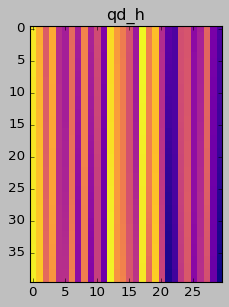

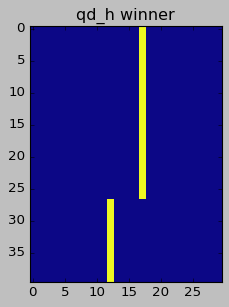

Epoch: 1000 	 Loss: 0.001601


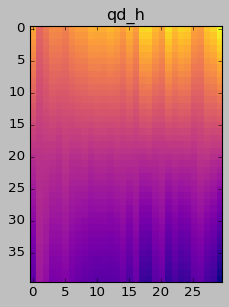

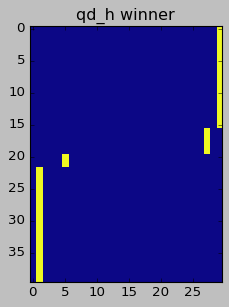

Epoch: 2000 	 Loss: 0.001543


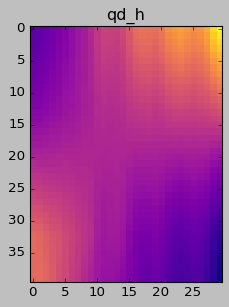

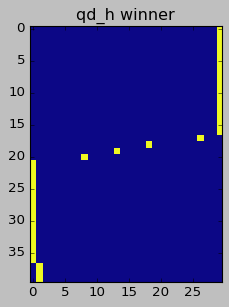

Epoch: 3000 	 Loss: 0.000975


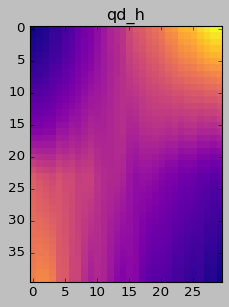

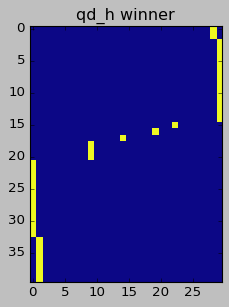

Epoch: 4000 	 Loss: 0.000848


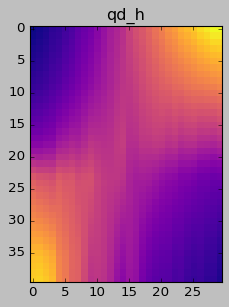

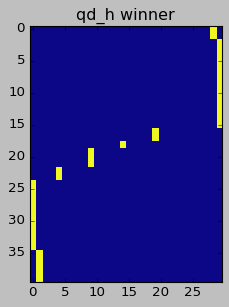

Epoch: 5000 	 Loss: 0.000834


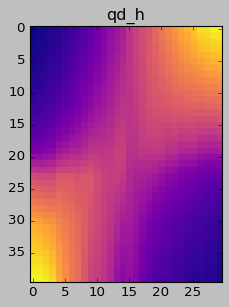

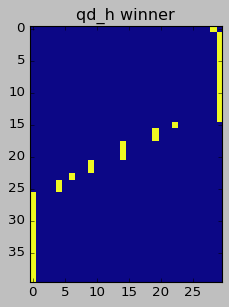

Epoch: 6000 	 Loss: 0.000722


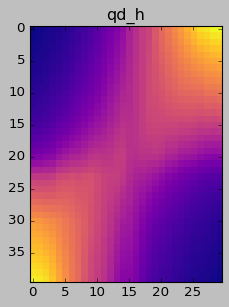

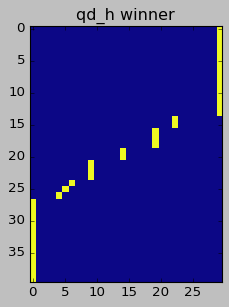

Epoch: 7000 	 Loss: 0.000689


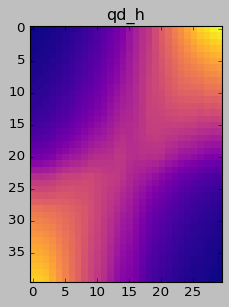

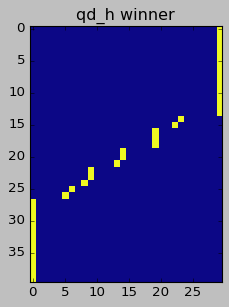

Epoch: 8000 	 Loss: 0.000656


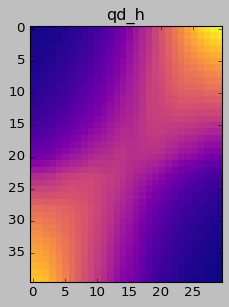

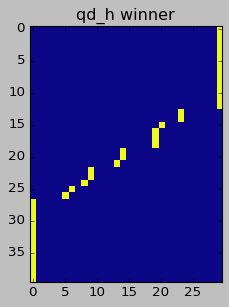

Epoch: 9000 	 Loss: 0.000629


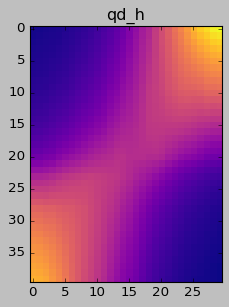

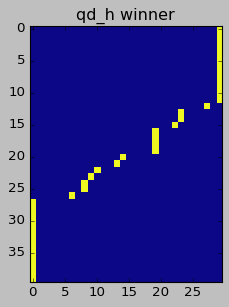

In [100]:
resolution = 30


model = QDAE(input_output_size=1, hidden_size=resolution, latent_feature_count=1, resolution=resolution)

#for param in model.parameters():
    # print(type(param.data), param.size())
    #nn.init.constant(param.data, val=0.1)
    #param.data += 0.1
optimizer = optim.Adam(model.parameters(), lr=0.01)

X = torch.cat((
    #torch.tensor(np.arange(0, .50, .01)).unsqueeze(dim=1).float(),
    torch.tensor(np.arange(.0, .40, .01)).unsqueeze(dim=1).float(),
  ))
print("X", X.shape)
train(model=model, device=device, X=X, optimizer=optimizer, epochs=10000, log_interval=1000)

## Test

Test using range 0.0-1.0

Training used range 0.5-1.0

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


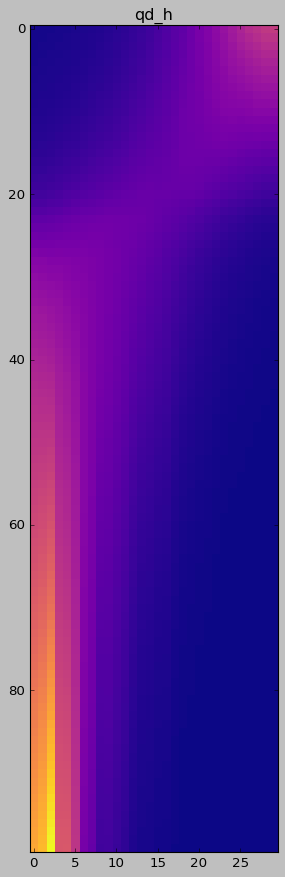

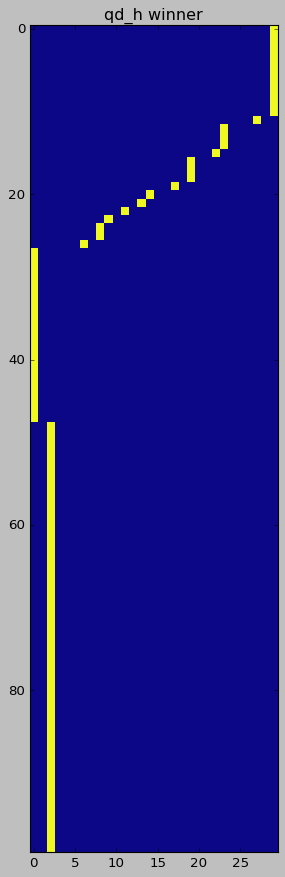

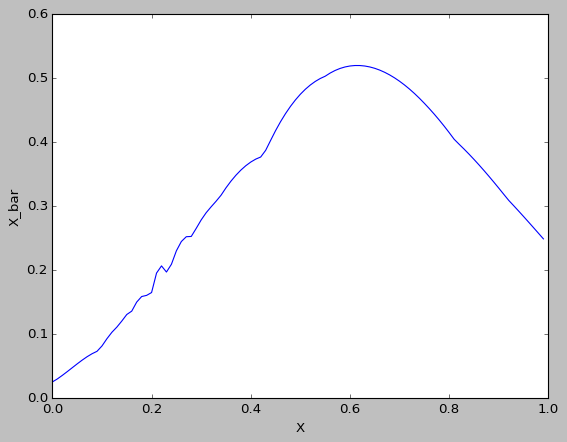

In [101]:
X = torch.tensor(np.arange(0.0, 1.0, 0.01)).unsqueeze(dim=1).float()
qd_h, X_bar = model(X)

show_image(qd_h.detach(), title="qd_h", print_values=False, figsize=(4, 80))
show_image((qd_h == qd_h.max(dim=1, keepdim=True)[0]).view_as(qd_h).detach(), title="qd_h winner", print_values=False, figsize=(4, 80))

plt.plot(X.detach().numpy(), X_bar.detach().numpy())
plt.xlabel("X")
plt.ylabel("X_bar")
plt.show()

## Confidence measurement

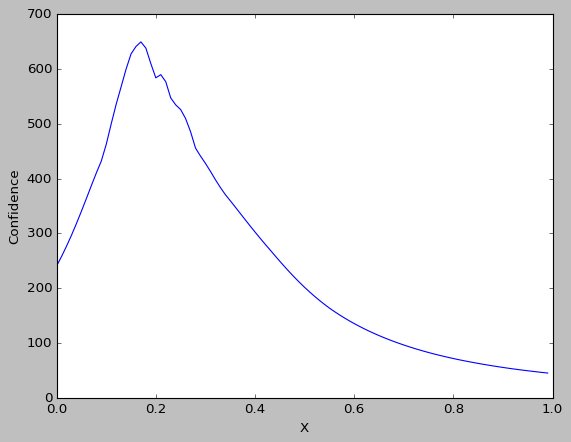

In [103]:
confidence = 1.0 / (qd_h[:, 0:-1] - qd_h[:, 1:]).pow(2).mean(dim=1).pow(0.5)
plt.xlabel("X")
plt.ylabel("Confidence")
plt.plot(X.detach().numpy(), confidence.detach().numpy())



*   In the range 0.5-1.0 that the model was trained on, confidence is higher than the range 0.0-0.5 where model has seen no training
*   confidence is low near 1.0. This seems to be an "edge effect" because right half of the gaussian-like activation is missing.

